# Airbnb data exploration

In this notebook we try to describe and explore the features of public datasets.

To look for more information about this public datasets look here: http://insideairbnb.com/get-the-data.html




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from utils import download_datasets

In [2]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache


In [3]:
#Reading files
datasets_cities = ['seattle', 'boston']

listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz')]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [5]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6285970453195562


In [6]:
#Computing scalers.
min_date = calendar.date.min()
max_date = calendar.date.max()

min_price = calendar.price.min()
max_price = calendar.price.max()

scaler_date = MinMaxScaler()
scaler_price = MinMaxScaler()

scaler_date.fit([[min_date.timestamp()], [max_date.timestamp()]])
scaler_price.fit([[min_price], [max_price]])


def slope_value(data):
  x = data.copy()
  x['date'] = x['date'].apply(lambda x: float(x.timestamp()))
  x = x.dropna()
  
  if x.shape[0] == 0:
    return np.nan
  
  X = x['date'].values.reshape(x['date'].shape[0], 1)
  y = x['price'].values.reshape(x['price'].shape[0], 1)
  
  X = scaler_date.transform(X)
  y = scaler_price.transform(y)
  
  lm = LinearRegression(n_jobs=-1)
  lm.fit(X, y)
  
  return lm.coef_[0][0]


def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.max()/x.price.min()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
slope = calendar.groupby('listing_id').apply(lambda x: slope_value(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


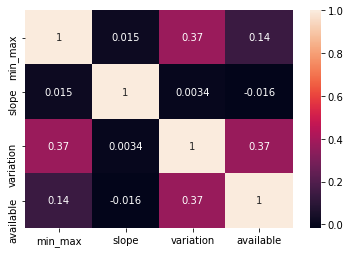

In [7]:
min_max.name = "min_max"
slope.name ="slope"
variation.name = "variation"
available.name = "available"



combined_metrics = pd.concat([min_max, slope, variation, available], axis=1)
corr_matrix = combined_metrics.corr()

sns.heatmap(corr_matrix, annot=True);

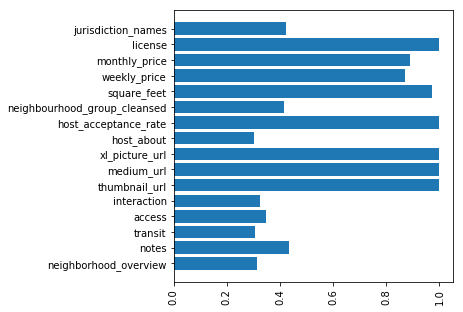

In [41]:
#Getting null % for each feature

plt.figure(1, figsize=(5, 5))
plt.xticks(rotation='vertical')
total_size = listings.shape[0]

labels_ = []
values_ = []
for feature in listings:
    nulls_percentage = listings[feature].isna().sum()/total_size
    if nulls_percentage > .3:
        labels_ += [feature]
        values_ += [nulls_percentage]
plt.barh(labels_, values_)
plt.show();